In [59]:
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize': (8.0, 8.0), 'font.size': 18})
from IPython.display import clear_output

import numpy as np
import math
from scipy.spatial.distance import cdist
from scipy.special import logsumexp

def rand_gauss(n, mu, cov):
    if cov.ndim == 1:
        cov = np.diag(cov)
    assert(mu.ndim == 1 and len(mu) == len(cov) and cov.ndim == 2 and cov.shape[0] == cov.shape[1])
    d, v = np.linalg.eigh(cov)
    return (np.random.randn(n, len(mu)) * np.sqrt(d)).dot(v) + mu

def logpdf_gauss(x, mu, cov):
    assert(mu.ndim == 1 and len(mu) == len(cov) and (cov.ndim == 1 or cov.shape[0] == cov.shape[1]))
    x = np.atleast_2d(x) - mu
    return -0.5*(len(mu)*np.log(2 * np.pi) + np.linalg.slogdet(cov)[1] + np.sum(x.dot(np.linalg.inv(cov)) * x, axis=1))
      
def plot2dfun(f, limits, resolution, ax=None):
    if ax is None:
        ax = plt
    xmin, xmax, ymin, ymax = limits
    xlim = np.arange(ymin, ymax, (ymax - ymin) / float(resolution))
    ylim = np.arange(xmin, xmax, (xmax - xmin) / float(resolution))
    a, b = np.meshgrid(ylim, xlim)
    img = f(np.vstack([np.ravel(a), np.ravel(b)[::-1]]).T)
    img = (img - img.min()) /(img.max() - img.min()) # normalize to range 0.0 - 1.0
    img = img.reshape(a.shape+img.shape[1:])
    return ax.imshow(img, cmap='gray', aspect='auto', extent=(xmin, xmax, ymin, ymax))

def gellipse(mu, cov, *args, **kwargs):
    """
    Contour plot of 2D Multivariate Gaussian distribution showing
    2 times standard deviation range around the mean.

    gellipse(mu, cov, n) plots ellipse given by mean vector MU and
    covariance matrix COV. Ellipse is plotted using N (default is 100)
    points. Additional parameters can specify various line types and
    properties. See description of matplotlib.pyplot.plot for more details.
    """
    n= kwargs.get('npoints', 100) 
    if len(mu) != 2 or cov.shape != (2, 2):
        raise RuntimeError('mu must be a two element vector and cov must be 2 x 2 matrix')

    d, v = np.linalg.eigh(4 * cov)
    d = np.diag(d)
    t = np.linspace(0, 2 * math.pi, n)
    x = v @ np.sign(d) @ np.sqrt(np.abs(d)) @ np.array([np.cos(t), np.sin(t)]) + mu[:,None]
    return plt.plot(x[0], x[1], *args, **kwargs)

# K-nearest neighbours example

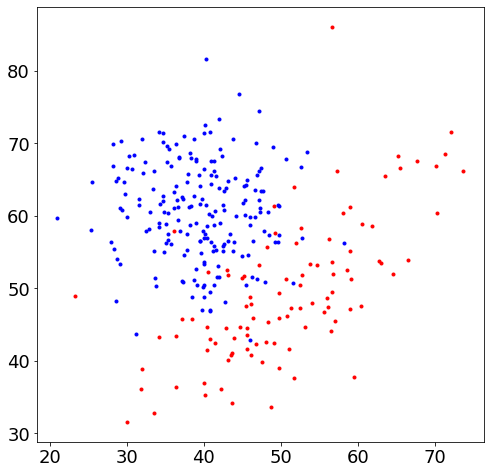

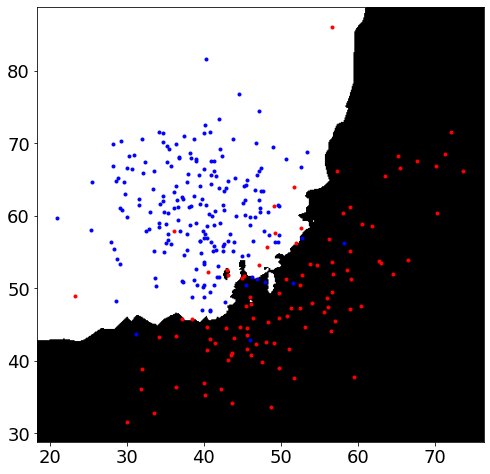

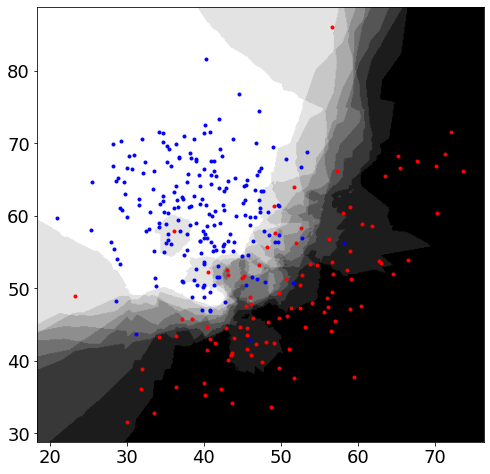

In [7]:
def k_nearest_neighbours(test_data, class1, class2, k):
    euclidean = cdist(np.r_[class1, class2], test_data)
    i = np.argsort(euclidean.T)
    return np.sum(i[:,:k] >= len(class1), axis=1) / float(k)


x1 = rand_gauss(100, np.array([50, 50]), np.array([[100, 70], [70, 100]]))
x2 = rand_gauss(200, np.array([40, 60]), np.array([[40, 0], [0, 40]]))
plt.plot(x1[:,0], x1[:,1], 'r.', x2[:,0], x2[:,1], 'b.')
ax = plt.axis()

k = 9

def soft_score(x):
  return k_nearest_neighbours(x, x1, x2, k)

def hard_decision(x):
  return (soft_score(x) > 0.5).astype(float)

plt.figure()
plot2dfun(hard_decision, ax, 500)
plt.plot(x1[:,0], x1[:,1], 'r.', x2[:,0], x2[:,1], 'b.')

plt.figure()
plot2dfun(soft_score, ax, 500)
plt.plot(x1[:,0], x1[:,1], 'r.', x2[:,0], x2[:,1], 'b.');

# Examples of 2D Multivariate Gaussian distribution

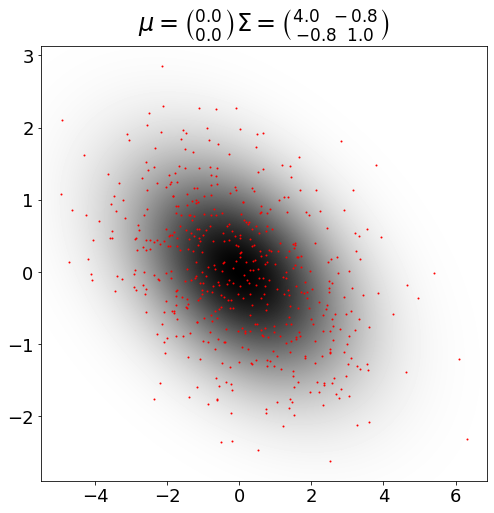

In [4]:
mu  = np.array([0.0, 0.0])
cov = np.array([[4.0, -0.8],
                [-0.8, 1.0]])
x = rand_gauss(500, mu, cov)
plt.plot(x[:,0], x[:,1], 'r.', markersize=2)
ax = plt.axis()

np.exp(logpdf_gauss(x, mu, cov))
plt.axis('equal')
plot2dfun(lambda x: 1-np.exp(logpdf_gauss(x, mu, cov)), ax, 500)
plt.title(r'$\mu=\binom{'+str(mu[0])+'}{'+str(mu[1])+r'}\Sigma=\binom{'+str(cov[0,0])+r'\ \ '+str(cov[0,1])+r'}{'+str(cov[1,0])+r'\ \ '+str(cov[1,1])+ r'}$', fontsize=24, pad=15);

# Example of Gaussian classifier

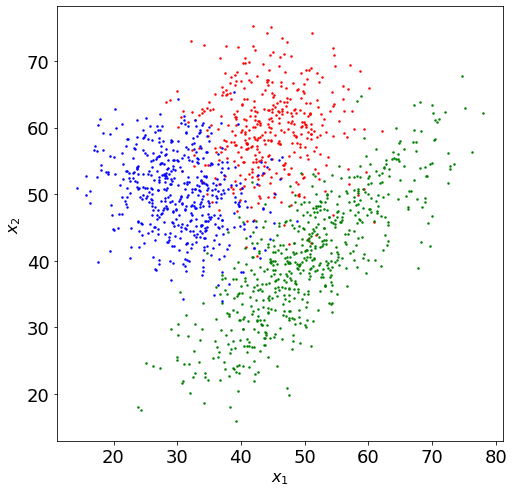

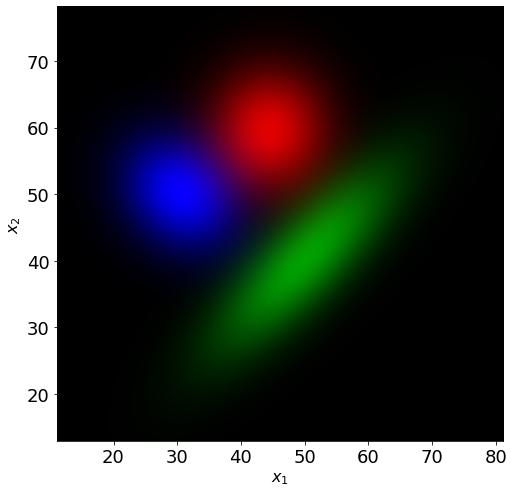

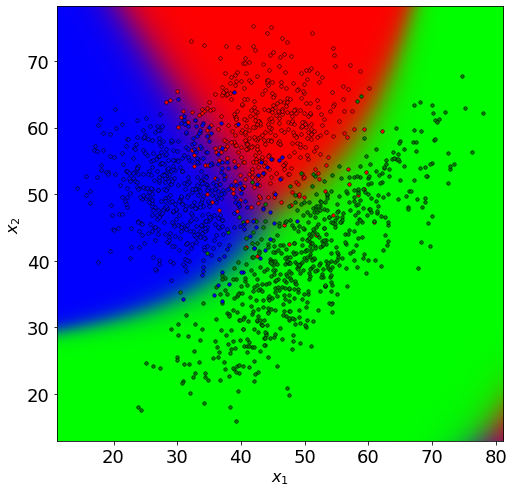

In [6]:
#Generate random data for classes x1, x2 and x3. The data for each class are
#generated from two gaussian distributions.
np.random.seed(0)
x1 = rand_gauss(400, np.array([45, 60]), np.array([[40, 0],   [0, 40]]))
x2 = rand_gauss(600, np.array([50, 40]), np.array([[100, 80], [80, 100]]))
x3 = rand_gauss(500, np.array([30, 50]), np.array([[40, -10], [-10, 40]]))

mus  = [np.mean(x, axis=0) for x in [x1, x2, x3]]
covs = [np.cov(x.T) for x in [x1, x2, x3]]
N = np.array([len(x1), len(x2), len(x3)], dtype=float)
P = N/N.sum()

# Plot the data
plt.plot(
    x1[:,0], x1[:,1], 'r.', 
    x2[:,0], x2[:,1], 'g.',
    x3[:,0], x3[:,1], 'b.',
    markersize=5, markeredgecolor='w', markeredgewidth=0
)
plt.xlabel('$x_1$', fontsize=16)
plt.ylabel('$x_2$', fontsize=16)
ax = plt.axis()

plt.figure()

def pdfs_for_all_classes(x):
  return np.vstack([np.exp(logpdf_gauss(x, mu, cov)) for mu, cov in zip(mus, covs)]).T
  
plot2dfun(pdfs_for_all_classes, ax, 500)
plt.xlabel('$x_1$', fontsize=16)
plt.ylabel('$x_2$', fontsize=16)

# compute posterior probability for class X1
def x1_posterior(x):
  joint_prob = pdfs_for_all_classes(x) * P
  return  joint_prob / joint_prob.sum(axis=1, keepdims=True)


# Plot the data with the posterior probability as the background
plt.figure()
plot2dfun(x1_posterior, ax, 500)
plt.plot(x1[:,0], x1[:,1], 'r.', 
         x2[:,0], x2[:,1], 'g.',
         x3[:,0], x3[:,1], 'b.',
         markersize=7, markeredgecolor='k', markeredgewidth=0.5)
plt.xlabel('$x_1$', fontsize=16)
plt.ylabel('$x_2$', fontsize=16);

# Classifying non-Gaussian data

In [8]:
def compute_ellipse(mu, cov, n):
    mu = mu.copy()
    if mu.shape == (2,):
        mu.shape = (2, 1)
    if mu.shape != (2, 1) or cov.shape != (2, 2):
        raise RuntimeError('mu must be a two element vector and cov must be 2 x 2 matrix')

    d, v = np.linalg.eigh(4 * cov)
    d = np.diag(d)
    t = np.linspace(0, 2 * math.pi, n)
    x = v @ np.sign(d) @ np.sqrt(np.abs(d)) @ np.array([np.cos(t), np.sin(t)]) + mu
    
    return x
    

def gellipse(mu, cov, n=100, *args, **kwargs):
    """
    Contour plot of 2D Multivariate Gaussian distribution.

    gellipse(mu, cov, n) plots ellipse given by mean vector MU and
    covariance matrix COV. Ellipse is plotted using N (default is 100)
    points. Additional parameters can specify various line types and
    properties. See description of matplotlib.pyplot.plot for more details.
    """
    x = compute_ellipse(mu, cov, n)
    return plt.plot(x[0], x[1], *args, **kwargs)


def train_gauss(x):
    """
    Estimates gaussian distribution from data.
    (MU, COV) = TRAIN_GAUSS(X) return Maximum Likelihood estimates of mean
    vector and covariance matrix estimated using training data X
    """
    return np.mean(x, axis=0), np.cov(x.T, bias=True)

(600, 2)


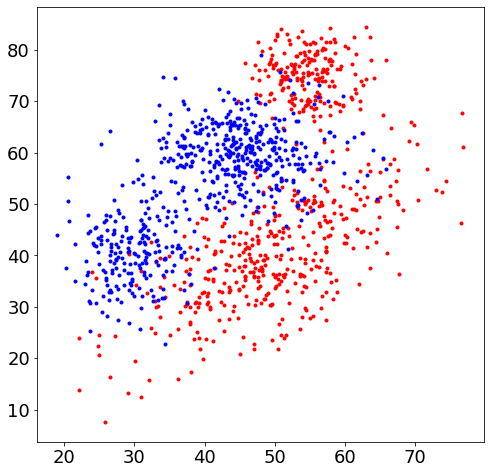

In [10]:
#Generate random data for classes X1 and X2. The data for each class are
#generated from two gaussian distributions. Hopefully, we will be able to
#learn these distributions from data using EM algorithm implemented in 
#'train_gmm' function.
x1 = np.r_[rand_gauss(400, np.array([50, 40]), np.array([[100, 70], [70, 100]])),
           rand_gauss(200, np.array([55, 75]), np.array([[25, 0], [0, 25]]))]
          
x2 = np.r_[rand_gauss(400, np.array([45, 60]), np.array([[40, 0], [0, 40]])),
           rand_gauss(200, np.array([30, 40]), np.array([[20, 0], [0, 40]]))]

print(x1.shape)

mu1, cov1 = train_gauss(x1)
mu2, cov2 = train_gauss(x2)
p1 = p2 = 0.5

# Plot the data
plt.plot(x1[:,0], x1[:,1], 'r.', x2[:,0], x2[:,1], 'b.')
plt.show();

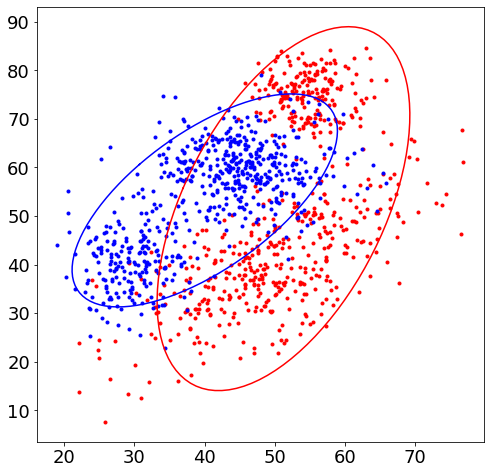

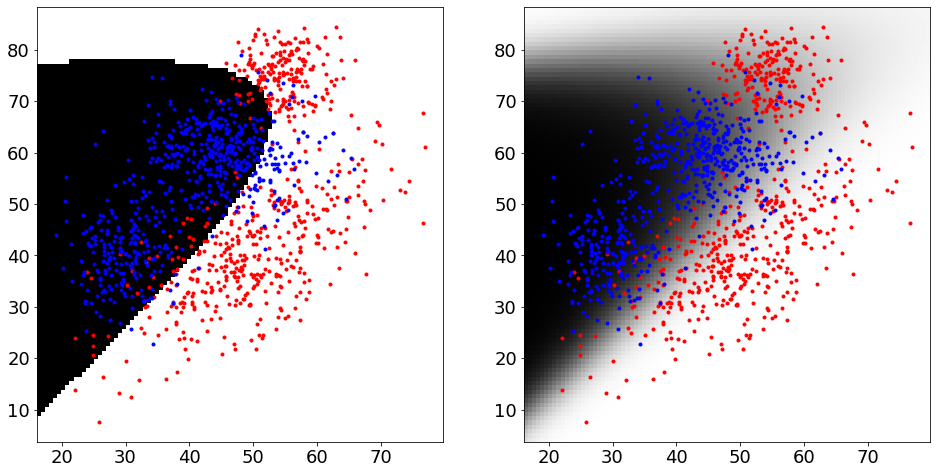

In [11]:
def hard_decision(x):
    class_1 = logpdf_gauss(x, mu1, cov1) + np.log(p1) > logpdf_gauss(x, mu2, cov2) + np.log(p2)
    return class_1.astype(np.float)
    
def x1_posterior(x):
    joint_1 = np.exp(logpdf_gauss(x, mu1, cov1) + np.log(p1))
    joint_2 = np.exp(logpdf_gauss(x, mu2, cov2) + np.log(p2))
    Z = joint_1 + joint_2
    return joint_1 / Z


plt.figure()
plt.plot(x1[:,0], x1[:,1], 'r.', x2[:,0], x2[:,1], 'b.')
ax = plt.axis()
gellipse(mu1, cov1, 100, 'r')
gellipse(mu2, cov2, 100, 'b')
plt.show()

plt.figure(figsize=(16, 8))
plt.subplot(121)
plt.plot(x1[:,0], x1[:,1], 'r.', x2[:,0], x2[:,1], 'b.')
plot2dfun(hard_decision, ax, 100)

plt.subplot(122)
plt.plot(x1[:,0], x1[:,1], 'r.', x2[:,0], x2[:,1], 'b.')
plot2dfun(x1_posterior, ax, 100)
plt.show()

## Building a GMM classifier

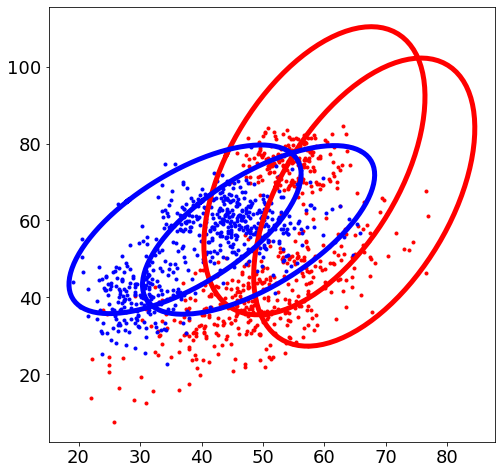

In [73]:
plt.rcParams.update({'figure.figsize': (8.0, 8.0), 'font.size': 18})

def plot_gmm(ws, mus, covs, *args, **kwargs):
    for w, mu, cov in zip(ws, mus, covs):
        gellipse2(mu, cov, *args, lw=10*w, **kwargs)
        
def train_gmm(x, ws, mus, covs):
    # E-step
    log_gamma = np.vstack([np.log(w) + logpdf_gauss(x, m, c) for w, m, c in zip(ws, mus, covs)])
    logevidence = logsumexp(log_gamma, axis=0) #  Marginalize components
    gamma = np.exp(log_gamma - logevidence)
    tll = logevidence.sum()
    gammasum = gamma.sum(axis=1) #  Marginalize datapoints
    
    # M-step
    ws = gammasum / len(x) # Normalize total responsibility by the number of datapoints
    mus = gamma @ x / gammasum[:, np.newaxis]
    covs = np.array([(gamma[i] * x.T) @ x / gammasum[i] - np.outer(mus[i], mus[i]) for i in range(len(ws))])
    
    return ws, mus, covs, tll

# Initialize 2 GMM models with full covariance matrices
m1 = 2  # Number of components
mus1 = x1[np.random.randint(1, len(x1), m1)]  #  Initialize means to random points from given class
covs1 = [cov1] * m1 #  Use the full cov matrix for both components
ws1 = np.ones(m1) / m1 #  Use uniform distribution as initial guess for the weights

m2 = 2
mus2 = x2[np.random.randint(1, len(x2), m2)]
covs2 = [cov2] * m2
ws2 = np.ones(m2) / m2
            
log_likelhood1 = []
log_likelhood2 = []

plt.plot(x1[:,0], x1[:,1], 'r.', x2[:,0], x2[:,1], 'b.')
plot_gmm(ws1, mus1, covs1, c='r')
plot_gmm(ws2, mus2, covs2, c='b')

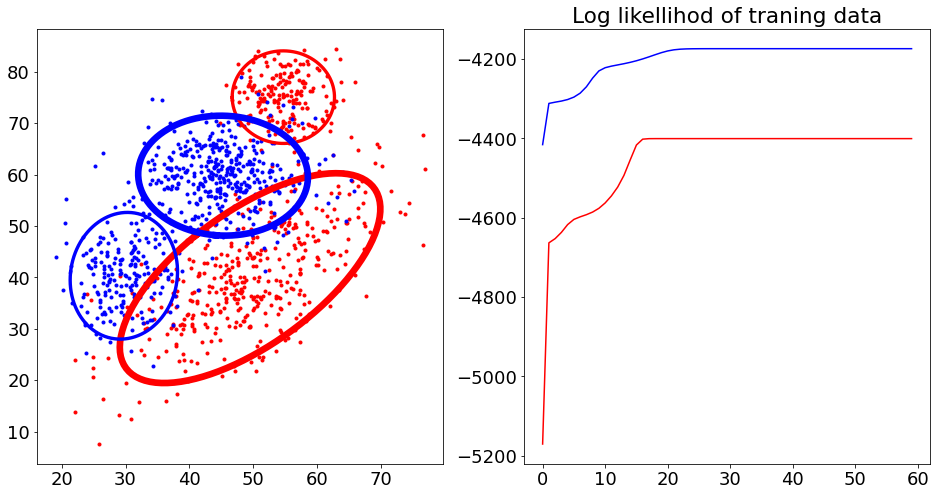

In [75]:
plt.rcParams.update({'figure.figsize': (16.0, 8.0), 'font.size': 18})

for i in range(30):
    ws1, mus1, covs1, tll1 = train_gmm(x1, ws1, mus1, covs1)
    ws2, mus2, covs2, tll2 = train_gmm(x2, ws2, mus2, covs2)
    log_likelhood1.append(tll1)
    log_likelhood2.append(tll2)
    clear_output(wait=True)
    plt.subplot(121)
    plt.plot(x1[:,0], x1[:,1], 'r.', x2[:,0], x2[:,1], 'b.')
    plot_gmm(ws1, mus1, covs1, c='r')
    plot_gmm(ws2, mus2, covs2, c='b')
    plt.subplot(122)
    plt.plot(log_likelhood1, 'r', log_likelhood2, 'b')
    plt.title("Log likellihod of traning data")
    plt.show()

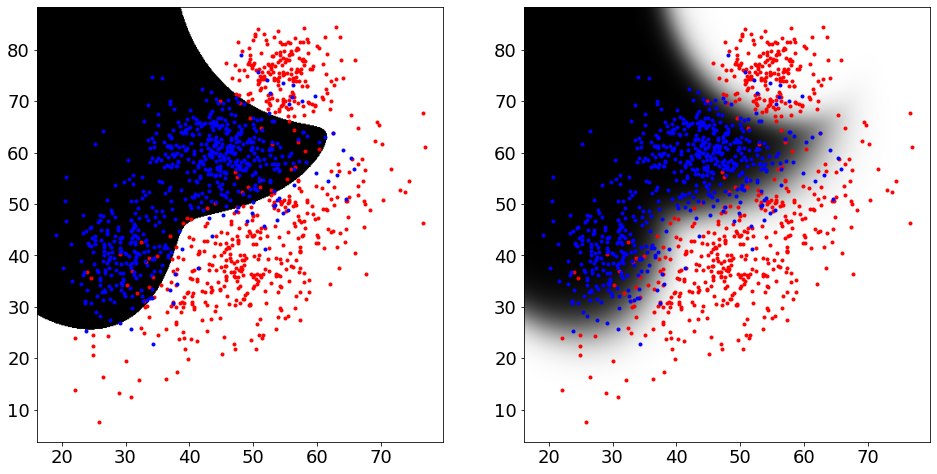

In [76]:
def logpdf_gmm(x, ws, mus, covs):
    return logsumexp([np.log(w) + logpdf_gauss(x, m, c) for w, m, c in zip(ws, mus, covs)], axis=0)

def hard_decision(x):
    log_joint_1 = logpdf_gmm(x, ws1, mus1, covs1) + np.log(p1)
    log_joint_2 = logpdf_gmm(x, ws2, mus2, covs2) + np.log(p2)
    return  (log_joint_1 > log_joint_2).astype(np.float)

def soft_decision(x):
    joint_1 = np.exp(logpdf_gmm(x, ws1, mus1, covs1) + np.log(p1))
    joint_2 = np.exp(logpdf_gmm(x, ws2, mus2, covs2) + np.log(p2))
    Z = joint_1 + joint_2
    return  joint_1 / Z
        

plt.figure(figsize=(16, 8))
plt.subplot(121)
plt.plot(x1[:,0], x1[:,1], 'r.')
plt.plot(x2[:,0], x2[:,1], 'b.')
plot2dfun(hard_decision, plt.axis(), 500)

plt.subplot(122)
plt.plot(x1[:,0], x1[:,1], 'r.')
plt.plot(x2[:,0], x2[:,1], 'b.')
plot2dfun(soft_decision, plt.axis(), 500)
plt.show()